In [8]:
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import matplotlib as mpl
import numpy.ma as ma
from scipy import interpolate
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/upwelling_depth/')
import upwelling_functions
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions
import quicklook

import warnings
warnings.filterwarnings("ignore")

import time
from datetime import datetime 

In [29]:
def get_varb_surf(vosaline_array, salt, varb):
    
    if len(vosaline_array.shape)==1:
        f = interpolate.interp1d(vosaline_array, varb)
        ynew = f(salt)
        varb_array = ynew
        
    elif len(vosaline_array.shape)!=1:
        varb_array = np.full([vosaline_array.shape[-2], vosaline_array.shape[-1]], np.nan)
        for i in range(vosaline_array.shape[-1]):
            for j in range(vosaline_array.shape[-2]):
                vosaline_column = vosaline_array[:, j, i]
                if len(varb.shape)==1:
                    varb_column = varb
                elif len(varb.shape)==3:
                    varb_column = varb[:, j, i]

                try:
                    f = interpolate.interp1d(vosaline_column, varb_column)
                    ynew = f(salt)
                    varb_array[j, i] = ynew
                except ValueError:
                    varb_array[j, i] = np.nan  
                
    return varb_array

In [33]:
def get_varbs(kind, case, fname, meshmaskname, time_s):
    
    dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'
    
    filesU = general_functions.get_files(dirname, fname, 'grid_U')        
    filesV = general_functions.get_files(dirname, fname, 'grid_V')
    filesW = general_functions.get_files(dirname, fname, 'grid_W')
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    
    y,x = slice(1,-1,None), slice(1,-1,None)
    
    with scDataset(filesU) as dsU, scDataset(filesV) as dsV, scDataset(filesW) as dsW, scDataset(filesT) as dsT:
        vozocrtx = dsU.variables['vozocrtx'][time_s,:,y,x]
        vomecrty = dsV.variables['vomecrty'][time_s,:,y,x]
        vovecrtz = dsW.variables['vovecrtz'][time_s,:,y,x]
        vosaline = dsT.variables['vosaline'][time_s, :, y, x]
        
    with nc.Dataset(os.path.join(dirname, meshmaskname), 'r') as dsM:
        e1t0 = np.nanmean(dsM.variables['e1t'][0, y, x], axis=0)
        e2t0 = np.nanmean(dsM.variables['e2t'][0, y, x], axis=1)
        e1t = np.cumsum(e1t0) / 1000 # km
        e2t = np.cumsum(e2t0) / 1000 # km
        
    print(kind, time_s)
        
    return vozocrtx, vomecrty, vovecrtz, vosaline, e1t, e2t

In [36]:
def plot_surface_snapshot(ax, kind, time_s, lab, salt, vmax):
    
    fs_numb, fs_str = 25, 30
    
    if kind == 'ideal':
        x_left, y_bottom = 205.822543591543,24.85159075988878
        inds = [90, 10]
        mid = 306
    elif kind == 'real':
        x_left, y_bottom = 296.29431501679437, 24.85159075988878
        inds = [130, 10]
        mid = 400
    
    salt_UHW_SA, salt_ATW_SA = 33.26258156425155, 34.99102991139694
    if salt == 'UHW':
        salt = salt_UHW_SA
        vm0 = [0, 0.27]
        mp = 0.22
    elif salt == 'ATW':
        salt = salt_ATW_SA
        vm0 = [0, vmax]
        mp = 0.08
    
    arrow=1
    
    fname = 'MCKNZ_1h_20170101_201701*'
    meshmaskname = 'mesh_mask.nc'
    
    case = 'base'
    dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'

    vozocrtx, vomecrty, vovecrtz, vosaline, e1t, e2t = get_varbs(kind, case, fname, meshmaskname, time_s)
    u_daily = get_varb_surf(vosaline, salt, vozocrtx)
    v_daily = get_varb_surf(vosaline, salt, vomecrty)
    x_slice, y_slice, u_nstg, v_nstg, speeds = quicklook.get_speeds(u_daily, v_daily, arrow)
    
    cmap, norm = cmo.cm.delta, upwelling_functions.MidpointNormalize(midpoint=mp)
    cmap.set_bad('#8b7765')
    
    #p = ax.pcolormesh(e1t, e2t, speeds, cmap=cmap, vmin=vm0[0], vmax=vm0[1], norm=norm)
    
    # ------------------
    cmap, norm = cmo.cm.balance, upwelling_functions.MidpointNormalize(midpoint=0)
    vovecrtz_daily = get_varb_surf(vosaline, salt, vovecrtz)
    p = ax.pcolormesh(e1t, e2t, vovecrtz_daily, cmap=cmap, vmin=-vmax, vmax=vmax, norm=norm)
    # ------------------
    
    ax.tick_params(axis='both', which='both', length=0, labelsize=fs_numb)
    ax.set_aspect(aspect='equal')
    ax.set_title('Hour '+str(time_s+1), fontsize=fs_str)
    
    cbar = fig.colorbar(p, ax=ax)
    cbar.ax.tick_params(labelsize=fs_numb)
    cbar.ax.set_ylabel('Horizontal speeds [ms$^{-1}$]', fontsize=fs_str)
    

#     ind_y = 180
#     ind_y_mid = ind_y + (max_y-ind_y)*0.5
#     ax.add_patch(patches.Rectangle((min_x, ind_y),(max_y-ind_y),(max_y-ind_y),
#                                    fc='w', ec='k', lw=1.5, alpha=1, zorder=8))
#     ax.annotate(lab, xy=(min_x+(max_y-ind_y)*0.5, ind_y_mid),
#                 fontsize=fs_str, weight='bold', va='center', ha='center', zorder=9)
    
    return ax, p

ideal 95


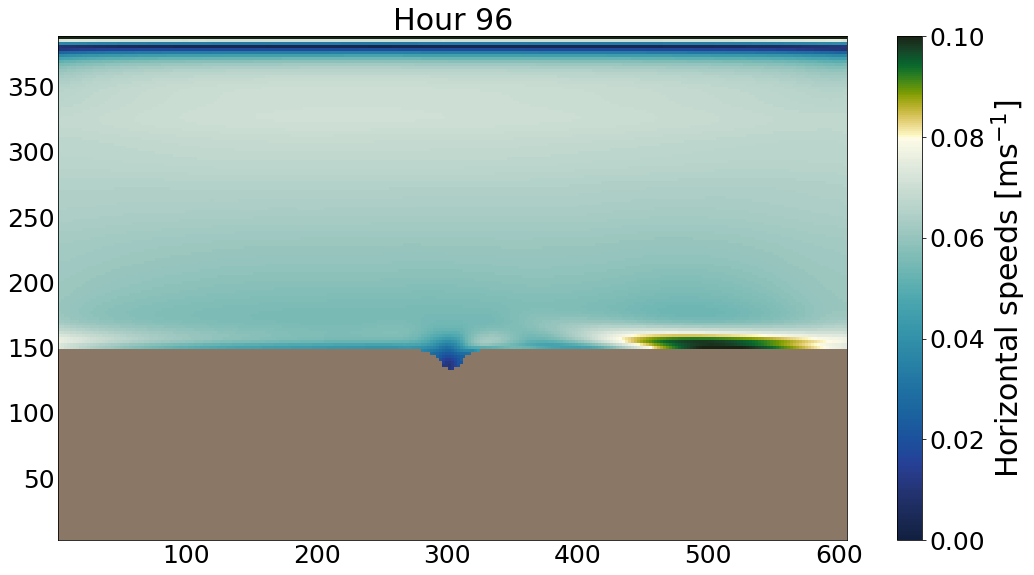

In [24]:
time_s = 95
fig, ax = plt.subplots(1,1,figsize=(15, 8))
ax, p = plot_surface_snapshot(ax, 'ideal', time_s, 'b', 'ATW', 0.1)
fig.tight_layout()
fig.patch.set_facecolor('white')    
fig.savefig('./fig_edge.png', dpi=200, bbox_inches='tight', format='png', facecolor=fig.get_facecolor())

real 12
real 18
real 24
real 30
real 36
real 42
real 48
real 54
real 60
real 66
real 72
real 78
real 84
real 90
real 96
real 102
real 108
real 114
real 120


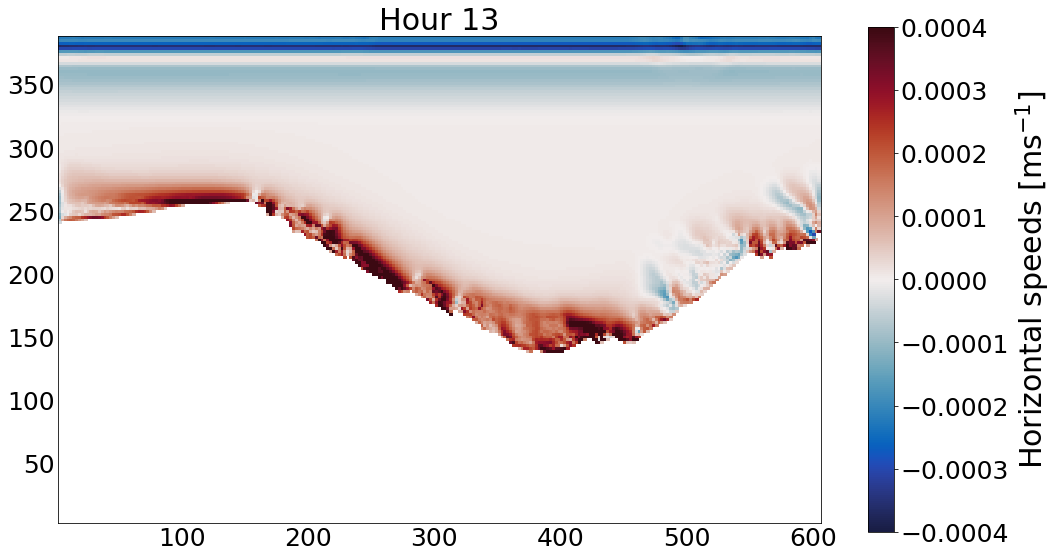

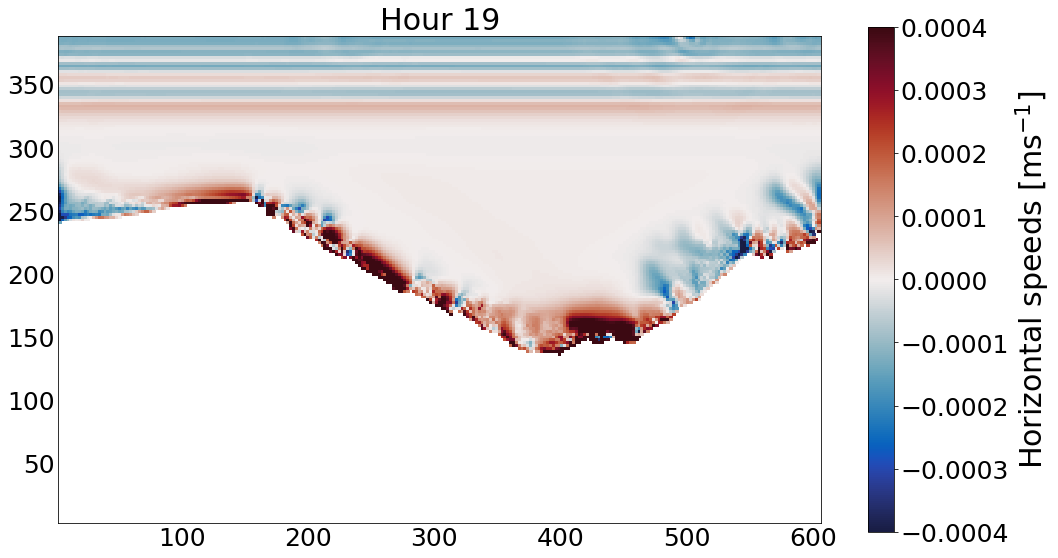

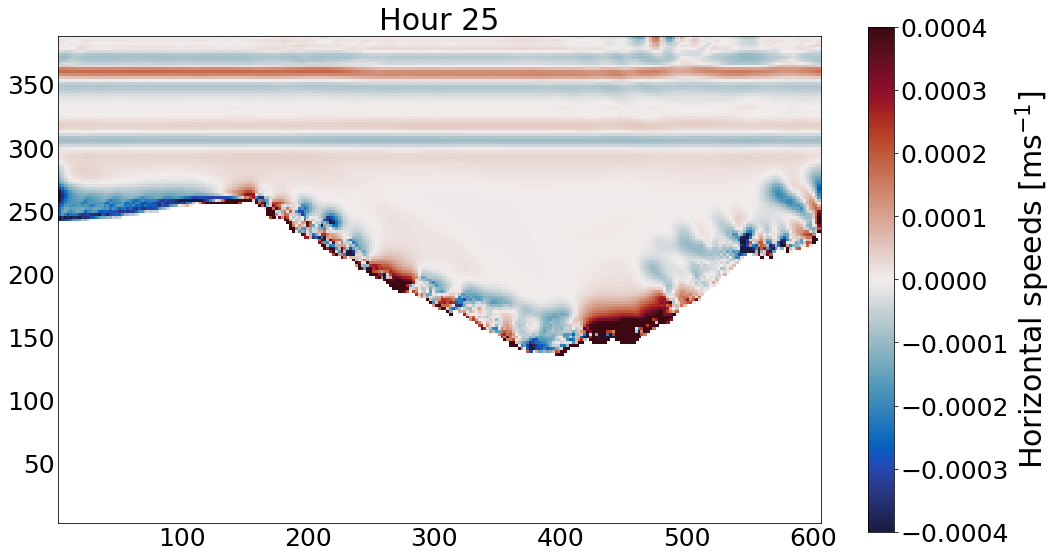

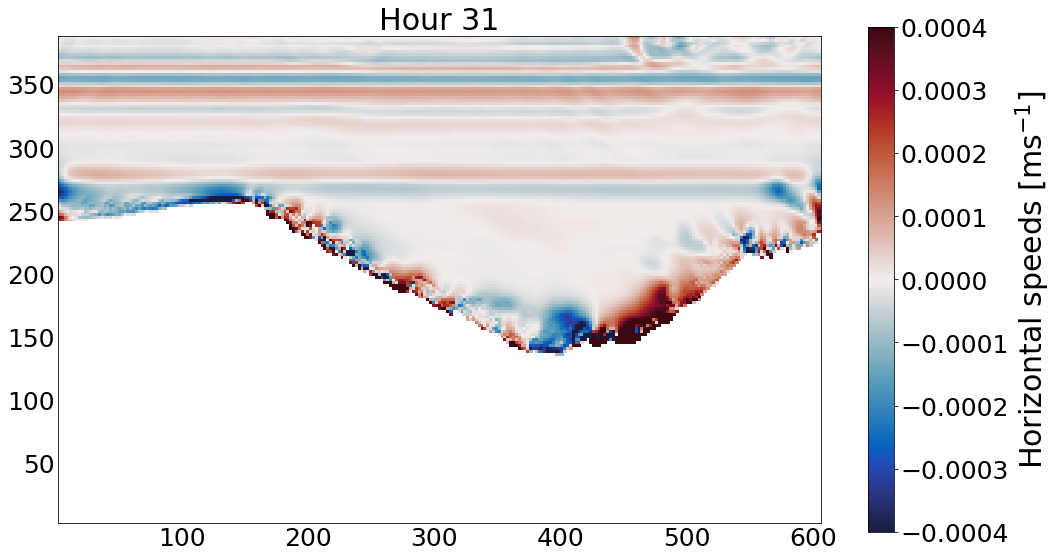

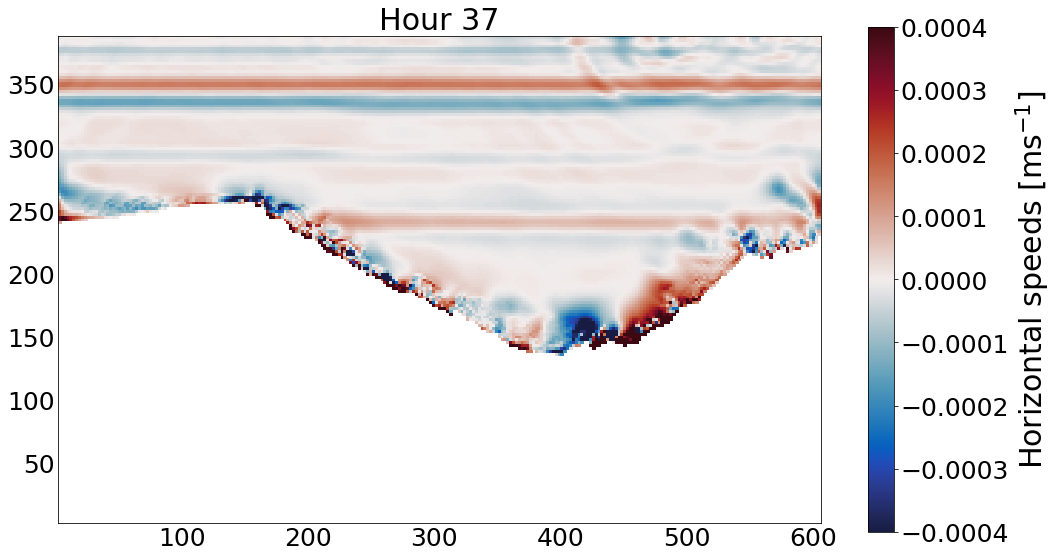

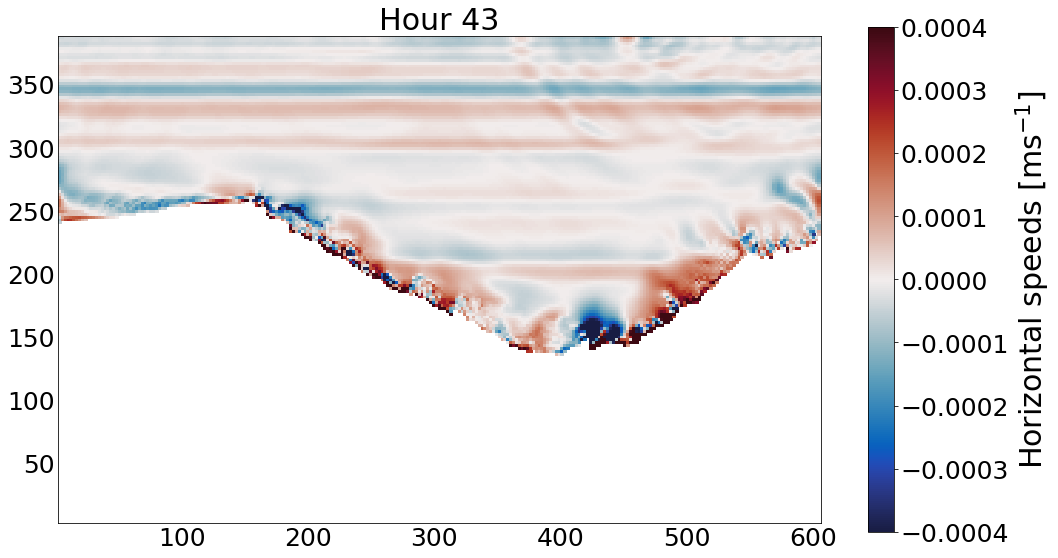

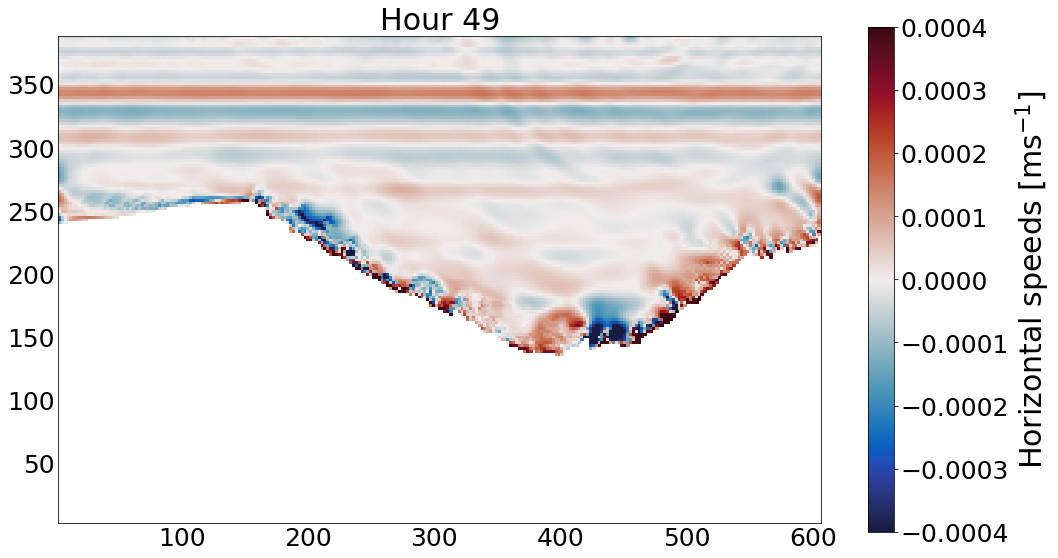

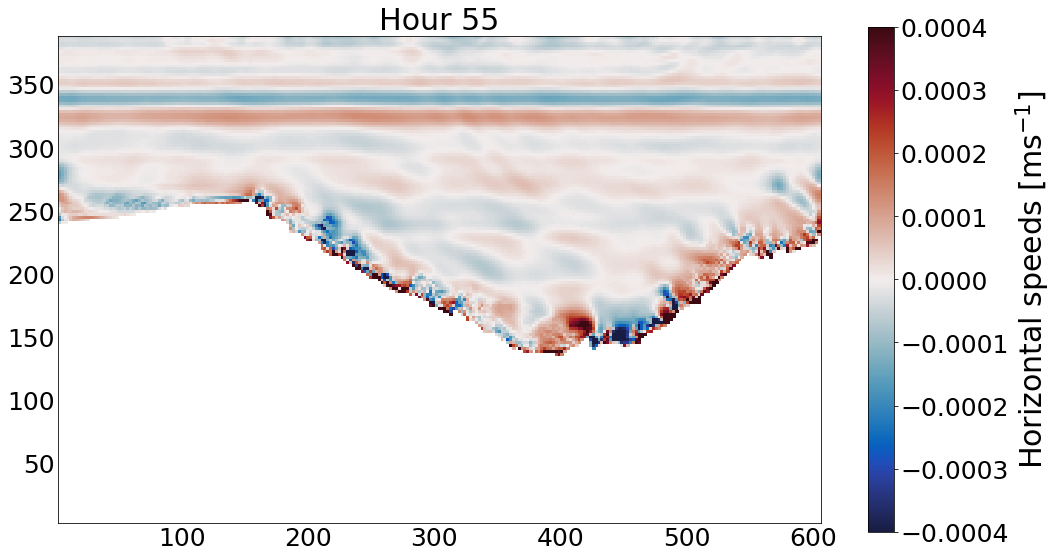

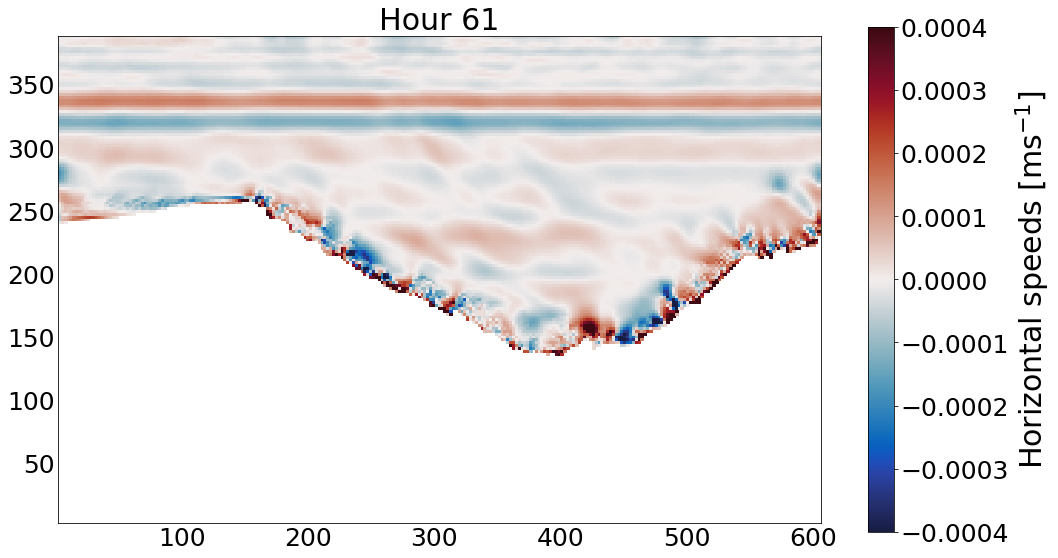

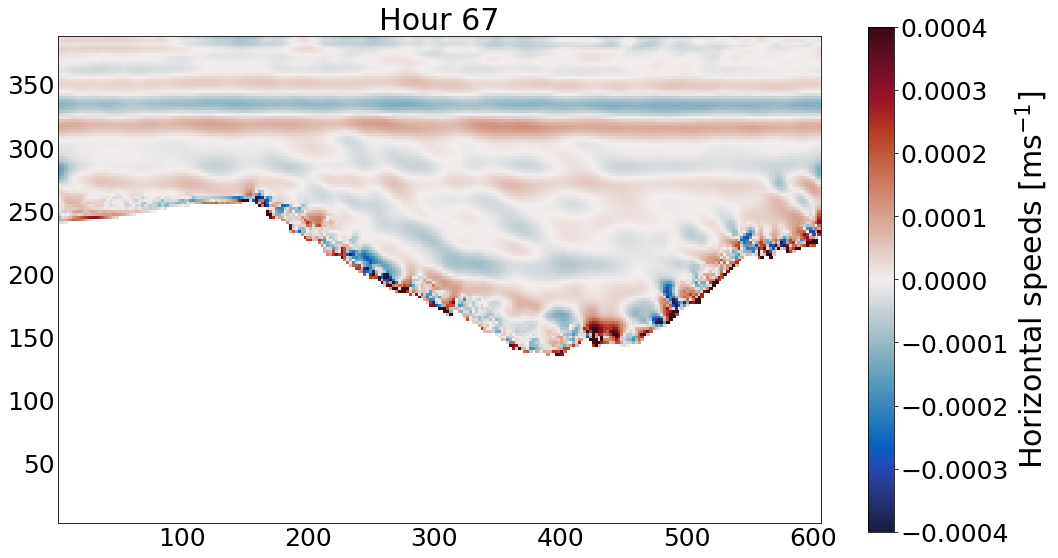

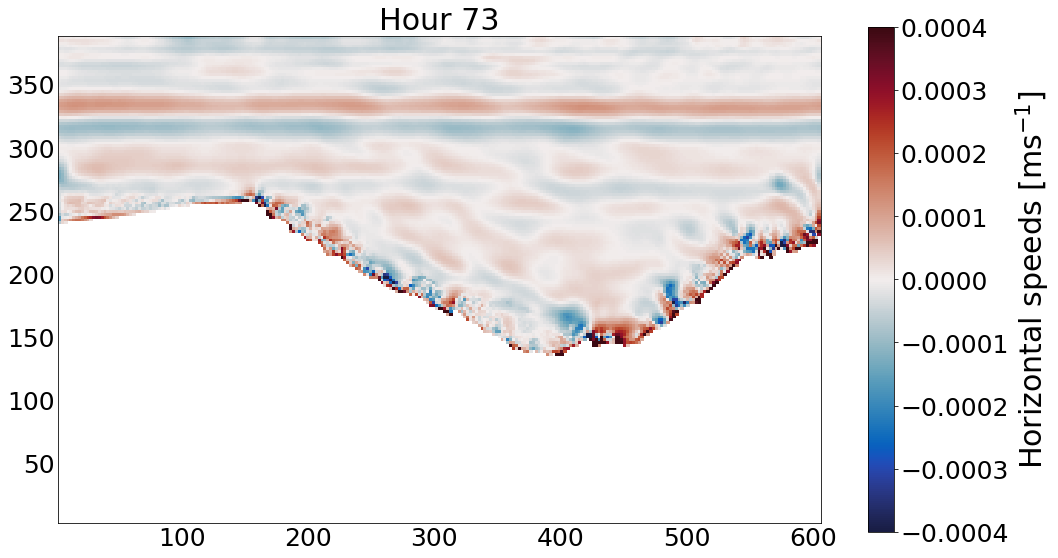

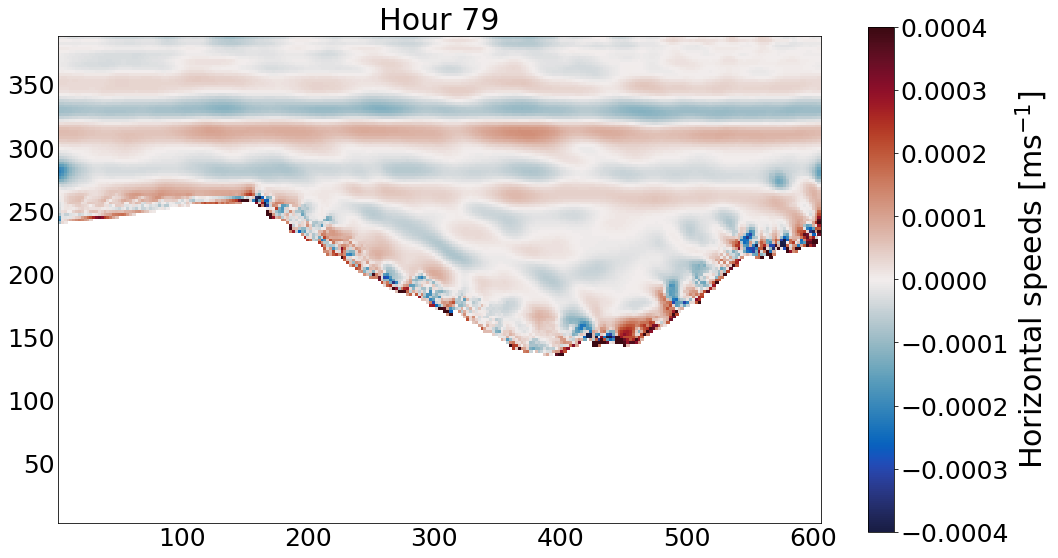

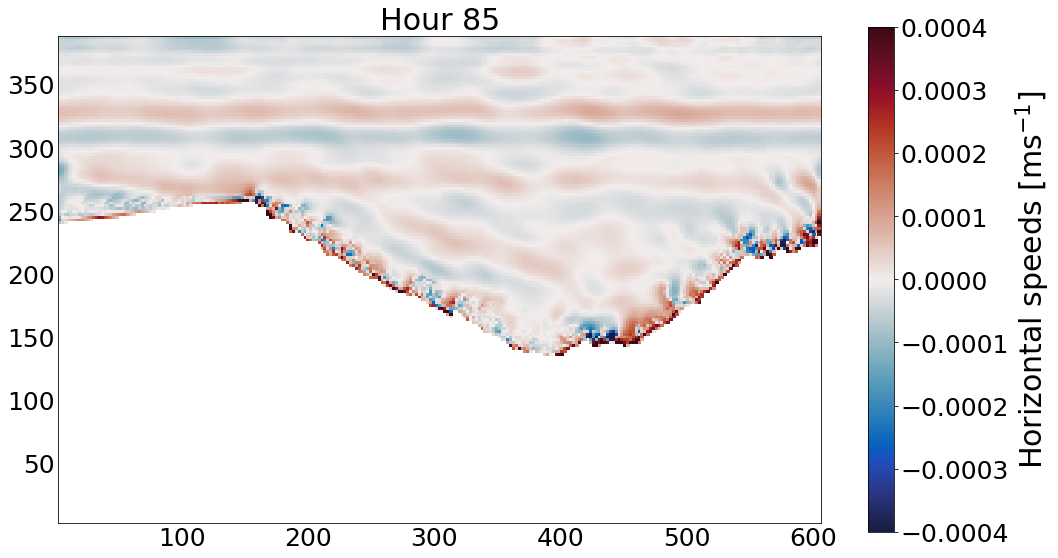

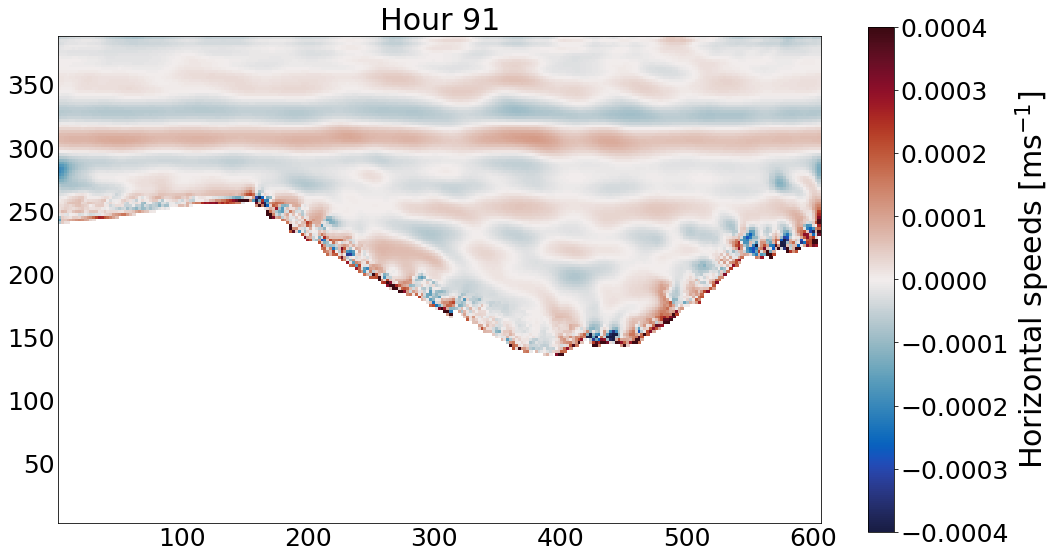

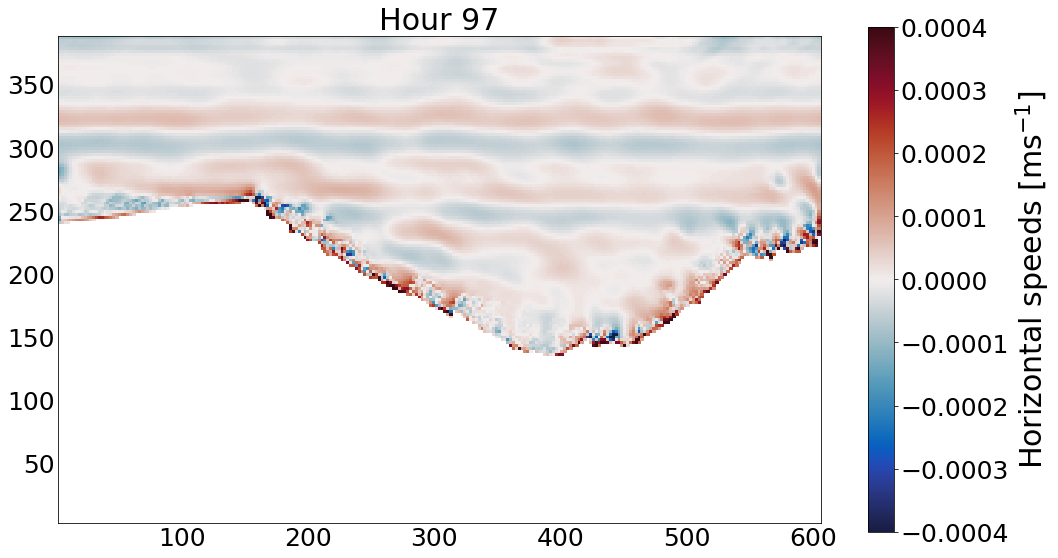

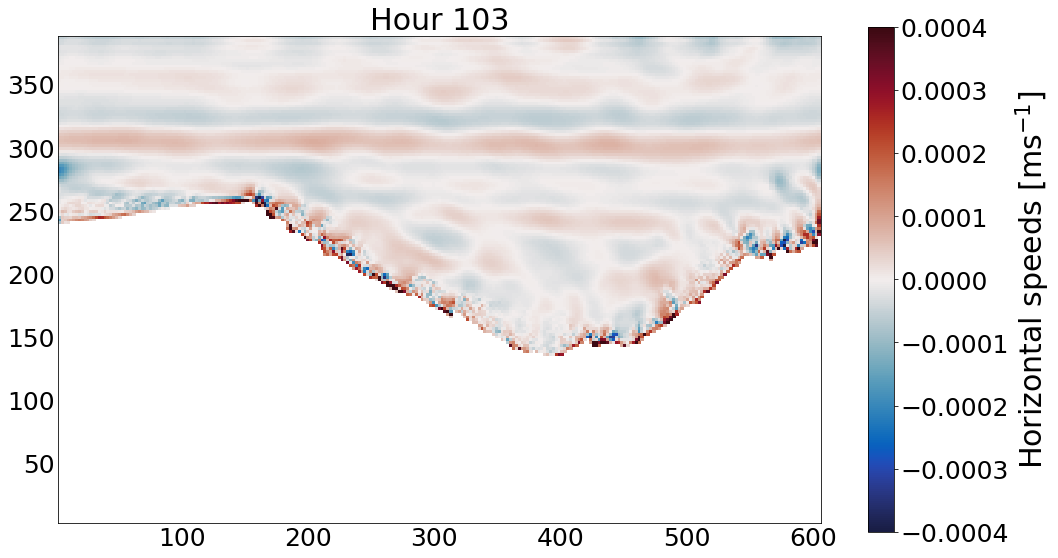

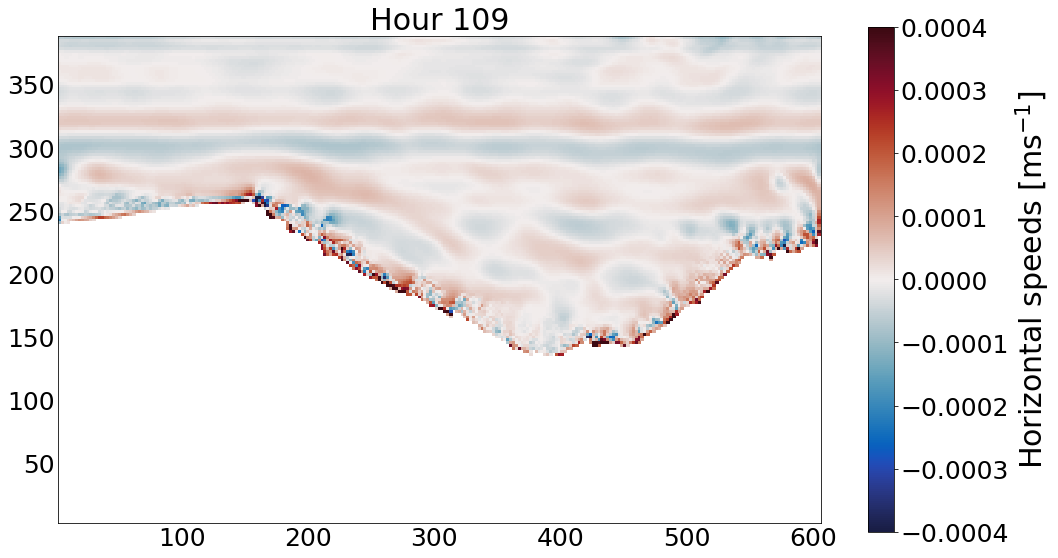

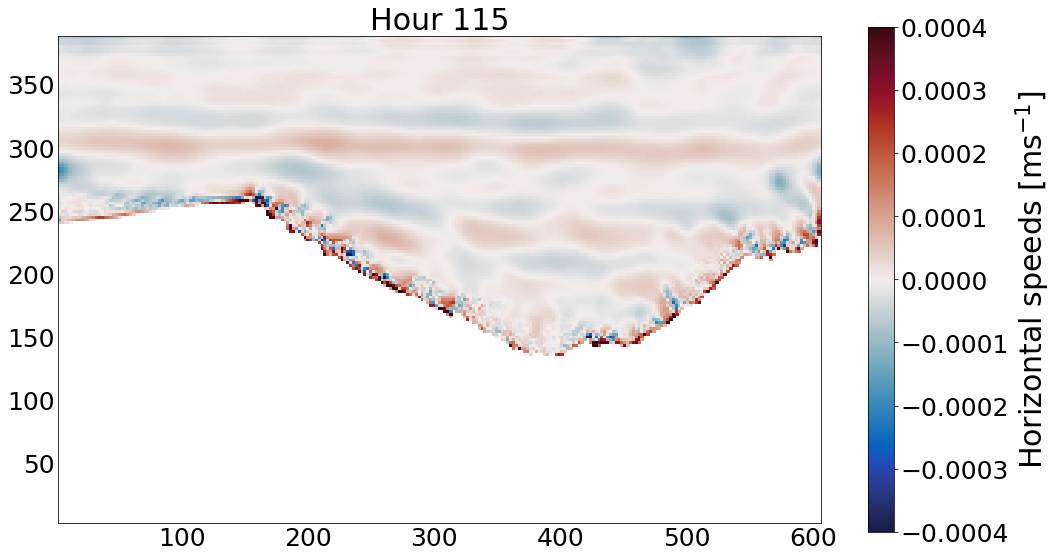

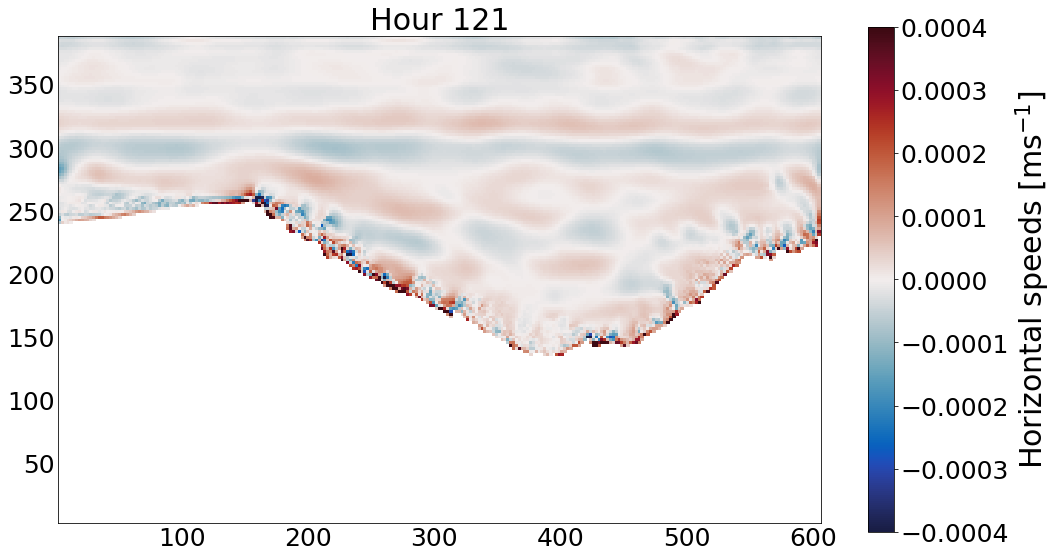

In [39]:
for time_s in np.arange(12, 121, 6):
    fig, ax = plt.subplots(1,1,figsize=(15, 8))
    ax, p = plot_surface_snapshot(ax, 'real', time_s, 'b', 'ATW', 0.0004)
    fig.tight_layout()
    fig.patch.set_facecolor('white')    
    #fig.savefig('./fig_edge.png', dpi=200, bbox_inches='tight', format='png', facecolor=fig.get_facecolor())